In [357]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
import datetime
import os
from pprint import pprint
import matplotlib.pyplot as plt
import time
import vectorbt as vbt
from time import time
import helpers as pth
import scipy.stats as stats

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20)

plt.style.use("classic")
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["axes.formatter.limits"] = [-1000000000, 1000000000]

In [358]:
I = pth.load_instruments()

### Information Coefficient

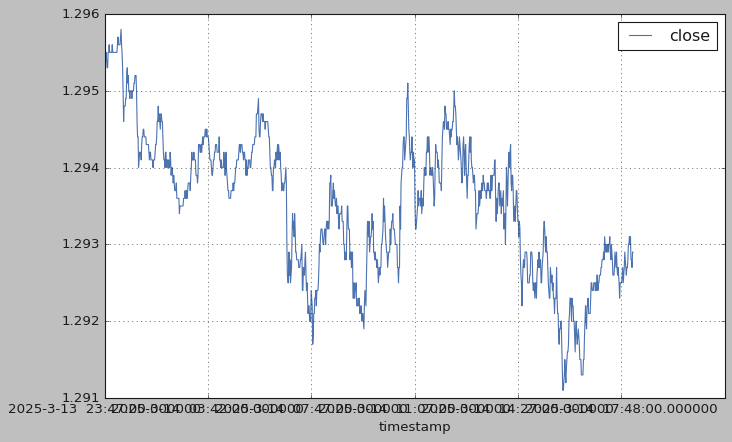

In [359]:
df = I["6B"].iloc[-1024:][["close"]]
df.plot()
plt.show()

In [360]:
periods = range(5, 65, 5)
for p in periods:
    df[f"frets_{p}"] = df.close.pct_change(-p)

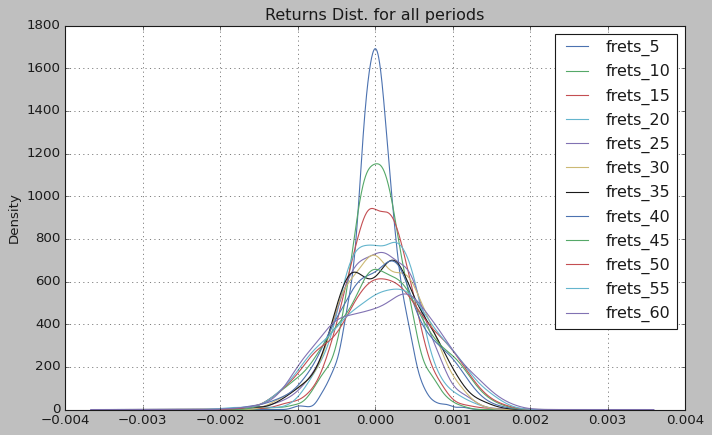

In [361]:
df.dropna(inplace=True)
for p in periods:
    df[f"frets_{p}"].plot(
        kind="kde", legend=True, title="Returns Dist. for all periods"
    )
plt.show()

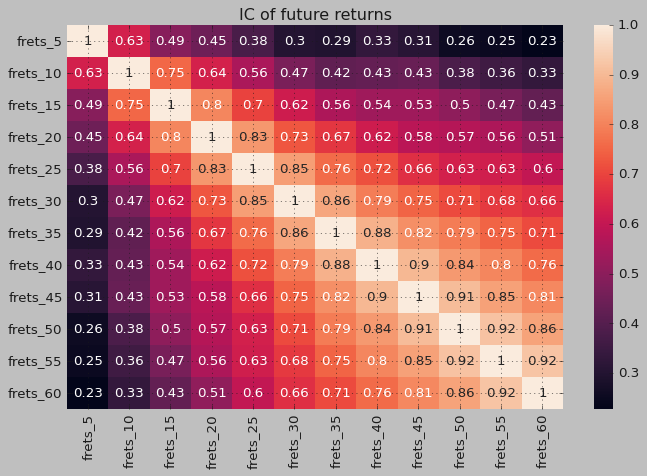

In [362]:
import seaborn as sns

cmatrix = df[[c for c in df.columns if c != "close"]].corr(method="spearman")
sns.heatmap(cmatrix, annot=True)
plt.title("IC of future returns")
plt.show()

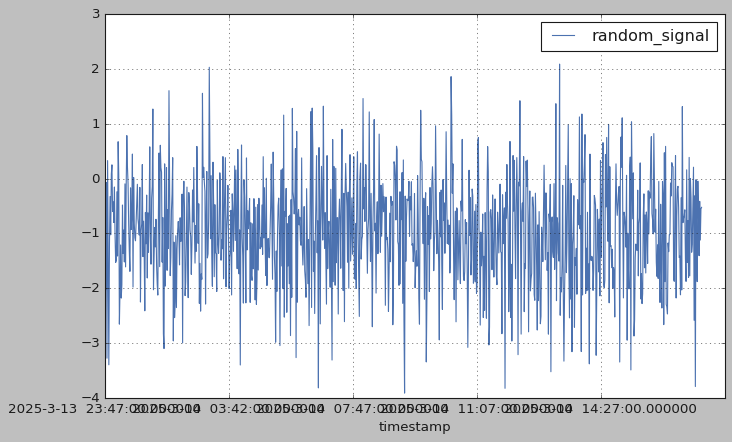

In [363]:
df["random_signal"] = np.random.normal(-1, 1, size=df.shape[0])
df.random_signal.plot(legend=True)
plt.show()

In [364]:
print("-------CORRELATION OF RANDOM_SIGNAL WITH FUTURE RETURNS-------\n")
for c in df.columns:
    if "rets" in c:
        current = stats.spearmanr(df["random_signal"], df[c])
        print(f"IC for C={c} -> {current.statistic}")

-------CORRELATION OF RANDOM_SIGNAL WITH FUTURE RETURNS-------

IC for C=frets_5 -> 0.006386951744378722
IC for C=frets_10 -> 0.010041303998551304
IC for C=frets_15 -> -0.034454231524224714
IC for C=frets_20 -> -0.006807160749902224
IC for C=frets_25 -> -0.057204968975545334
IC for C=frets_30 -> -0.04085191652462807
IC for C=frets_35 -> -0.004580147682030905
IC for C=frets_40 -> -0.0046093030311832525
IC for C=frets_45 -> 0.002637920969577651
IC for C=frets_50 -> -0.009549420026507778
IC for C=frets_55 -> 0.020049721310821826
IC for C=frets_60 -> 0.005100470764839109


### Rolling Information Coefficient

In [365]:
res = df[["frets_5", "frets_10"]]
res

,frets_5,frets_10
timestamp,,
2025-3-13 23:47:00.000000,0.000077,-0.000077
2025-3-13 23:49:00.000000,0.000077,-0.000077
2025-3-13 23:51:00.000000,-0.000077,-0.000077
2025-3-13 23:53:00.000000,0.000000,0.000000
2025-3-13 23:54:00.000000,-0.000154,-0.000077
...,...,...
2025-3-14 17:06:00.000000,-0.000155,-0.000309
2025-3-14 17:07:00.000000,-0.000155,-0.000232
2025-3-14 17:08:00.000000,-0.000155,-0.000232


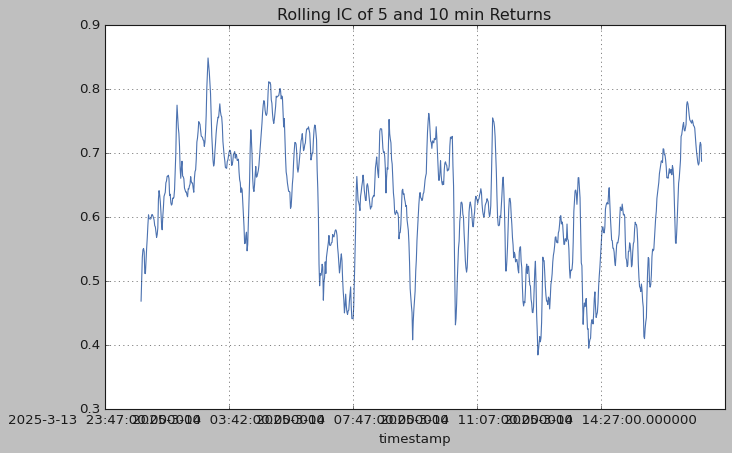

In [367]:
df.frets_5.rolling(window=60).apply(
    lambda x: abs(stats.spearmanr(x, df.frets_10.loc[x.index]).statistic), raw=False
).plot(title="Rolling IC of 5 and 10 min Returns")
plt.show()

In [375]:
# TODO: learn about t-test and add an example